# PPO实现CarPole-v1（离散动作空间）

## 1. 定义算法

### 1.1 定义模型

In [1]:
!export CUDA_VISIBLE_DEVICES=0,1

In [2]:
import torch.nn as nn
import torch.nn.functional as F
class ActorSoftmax(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super(ActorSoftmax, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        probs = F.softmax(self.fc3(x),dim=1)
        return probs
class Critic(nn.Module):
    def __init__(self,input_dim,output_dim,hidden_dim=256):
        super(Critic,self).__init__()
        assert output_dim == 1 # critic must output a single value
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)
        return value

### 1.2 定义经验回放

In [3]:
import random
from collections import deque
class ReplayBufferQue:
    '''DQN的经验回放池，每次采样batch_size个样本'''
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.buffer = deque(maxlen=self.capacity)
    def push(self,transitions):
        '''_summary_
        Args:
            trainsitions (tuple): _description_
        '''
        self.buffer.append(transitions)
    def sample(self, batch_size: int, sequential: bool = False):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        if sequential: # sequential sampling
            rand = random.randint(0, len(self.buffer) - batch_size)
            batch = [self.buffer[i] for i in range(rand, rand + batch_size)]
            return zip(*batch)
        else:
            batch = random.sample(self.buffer, batch_size)
            return zip(*batch)
    def clear(self):
        self.buffer.clear()
    def __len__(self):
        return len(self.buffer)

class PGReplay(ReplayBufferQue):
    '''PG的经验回放池，每次采样所有样本，因此只需要继承ReplayBufferQue，重写sample方法即可
    '''
    def __init__(self):
        self.buffer = deque()
    def sample(self):
        ''' sample all the transitions
        '''
        batch = list(self.buffer)
        return zip(*batch)

### 1.3 定义智能体

In [4]:
import torch
from torch.distributions import Categorical
class Agent:
    def __init__(self,cfg) -> None:
        
        self.gamma = cfg.gamma
        self.device = torch.device(cfg.device) 
        self.actor = ActorSoftmax(cfg.n_states,cfg.n_actions, hidden_dim = cfg.actor_hidden_dim).to(self.device)
        self.critic = Critic(cfg.n_states,1,hidden_dim=cfg.critic_hidden_dim).to(self.device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=cfg.actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=cfg.critic_lr)
        self.memory = PGReplay()
        self.k_epochs = cfg.k_epochs # update policy for K epochs
        self.eps_clip = cfg.eps_clip # clip parameter for PPO
        self.entropy_coef = cfg.entropy_coef # entropy coefficient
        self.sample_count = 0
        self.update_freq = cfg.update_freq

    def sample_action(self,state):
        self.sample_count += 1
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
        probs = self.actor(state)
        dist = Categorical(probs)
        action = dist.sample()
        self.log_probs = dist.log_prob(action).detach()
        return action.detach().cpu().numpy().item()
    @torch.no_grad()
    def predict_action(self,state):
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
        probs = self.actor(state)
        dist = Categorical(probs)
        action = dist.sample()
        return action.detach().cpu().numpy().item()
    def update(self):
        # update policy every n steps
        if self.sample_count % self.update_freq != 0:
            return
        # print("update policy")
        old_states, old_actions, old_log_probs, old_rewards, old_dones = self.memory.sample()
        # convert to tensor
        old_states = torch.tensor(np.array(old_states), device=self.device, dtype=torch.float32)
        old_actions = torch.tensor(np.array(old_actions), device=self.device, dtype=torch.float32)
        old_log_probs = torch.tensor(old_log_probs, device=self.device, dtype=torch.float32)
        # monte carlo estimate of state rewards
        returns = []
        discounted_sum = 0
        for reward, done in zip(reversed(old_rewards), reversed(old_dones)):
            if done:
                discounted_sum = 0
            discounted_sum = reward + (self.gamma * discounted_sum)
            returns.insert(0, discounted_sum)
        # Normalizing the rewards:
        returns = torch.tensor(returns, device=self.device, dtype=torch.float32)
        returns = (returns - returns.mean()) / (returns.std() + 1e-5) # 1e-5 to avoid division by zero
        for _ in range(self.k_epochs):
            # compute advantage
            values = self.critic(old_states) # detach to avoid backprop through the critic
            advantage = returns - values.detach()
            # get action probabilities
            probs = self.actor(old_states)
            dist = Categorical(probs)
            # get new action probabilities
            new_probs = dist.log_prob(old_actions)
            # compute ratio (pi_theta / pi_theta__old):
            ratio = torch.exp(new_probs - old_log_probs) # old_log_probs must be detached
            # compute surrogate loss
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * advantage
            # compute actor loss
            actor_loss = -torch.min(surr1, surr2).mean() + self.entropy_coef * dist.entropy().mean()
            # compute critic loss
            critic_loss = (returns - values).pow(2).mean()
            # take gradient step
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()
        self.memory.clear()

## 2. 定义训练

In [5]:
import copy
def train(cfg, env, agent):
    ''' 训练
    '''
    print("开始训练！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    best_ep_reward = 0 # 记录最大回合奖励
    output_agent = None
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state = env.reset()  # 重置环境，返回初始状态
        for _ in range(cfg.max_steps):
            ep_step += 1
            action = agent.sample_action(state)  # 选择动作
            next_state, reward, done, _ = env.step(action)  # 更新环境，返回transition
            agent.memory.push((state, action,agent.log_probs,reward,done))  # 保存transition
            state = next_state  # 更新下一个状态
            agent.update()  # 更新智能体
            ep_reward += reward  # 累加奖励
            if done:
                break
        if (i_ep+1)%cfg.eval_per_episode == 0:
            sum_eval_reward = 0
            for _ in range(cfg.eval_eps):
                eval_ep_reward = 0
                state = env.reset()
                for _ in range(cfg.max_steps):
                    action = agent.predict_action(state)  # 选择动作
                    next_state, reward, done, _ = env.step(action)  # 更新环境，返回transition
                    state = next_state  # 更新下一个状态
                    eval_ep_reward += reward  # 累加奖励
                    if done:
                        break
                sum_eval_reward += eval_ep_reward
            mean_eval_reward = sum_eval_reward/cfg.eval_eps
            if mean_eval_reward >= best_ep_reward:
                best_ep_reward = mean_eval_reward
                output_agent = copy.deepcopy(agent)
                print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.2f}，评估奖励：{mean_eval_reward:.2f}，最佳评估奖励：{best_ep_reward:.2f}，更新模型！")
            else:
                print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.2f}，评估奖励：{mean_eval_reward:.2f}，最佳评估奖励：{best_ep_reward:.2f}")
        steps.append(ep_step)
        rewards.append(ep_reward)
    print("完成训练！")
    env.close()
    return output_agent,{'rewards':rewards}

def test(cfg, env, agent):
    print("开始测试！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    for i_ep in range(cfg.test_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state = env.reset()  # 重置环境，返回初始状态
        for _ in range(cfg.max_steps):
            ep_step+=1
            action = agent.predict_action(state)  # 选择动作
            next_state, reward, done, _ = env.step(action)  # 更新环境，返回transition
            state = next_state  # 更新下一个状态
            ep_reward += reward  # 累加奖励
            if done:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg.test_eps}，奖励：{ep_reward:.2f}")
    print("完成测试")
    env.close()
    return {'rewards':rewards}

## 3. 定义环境

In [6]:
import gym
import os
import numpy as np
def all_seed(env,seed = 1):
    ''' 万能的seed函数
    '''
    if seed == 0:
        return
    # env.seed(seed) # env config
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
def env_agent_config(cfg):
    env = gym.make(cfg.env_name) # 创建环境
    all_seed(env,seed=cfg.seed)
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.n
    print(f"状态空间维度：{n_states}，动作空间维度：{n_actions}")
    # 更新n_states和n_actions到cfg参数中
    setattr(cfg, 'n_states', n_states)
    setattr(cfg, 'n_actions', n_actions) 
    agent = Agent(cfg)
    return env,agent

In [24]:
env = gym.make("CartPole-v1") # 创建环境
state = env.reset()
print(state)
state = torch.tensor(state, device="cpu", dtype=torch.float32).unsqueeze(dim=0)
print(state)
print(env.step(1))

[0.02682865 0.02882144 0.04064228 0.01623593]
tensor([[0.0268, 0.0288, 0.0406, 0.0162]])
(array([ 0.02740508,  0.22333768,  0.040967  , -0.26335195], dtype=float32), 1.0, False, {})


/home/liuhusheng/anaconda3/envs/rele/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


/home/liuhusheng/anaconda3/envs/rele/lib/python3.9/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/liuhusheng/anaconda3/envs/rele/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/liuhusheng/anaconda3/envs/rele/lib/python3.9/site-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/home/liuhusheng/anaconda3/envs/rele/lib/python

0     1.0 False
50     1.0 False
100     1.0 False
150     1.0 False
200     1.0 False


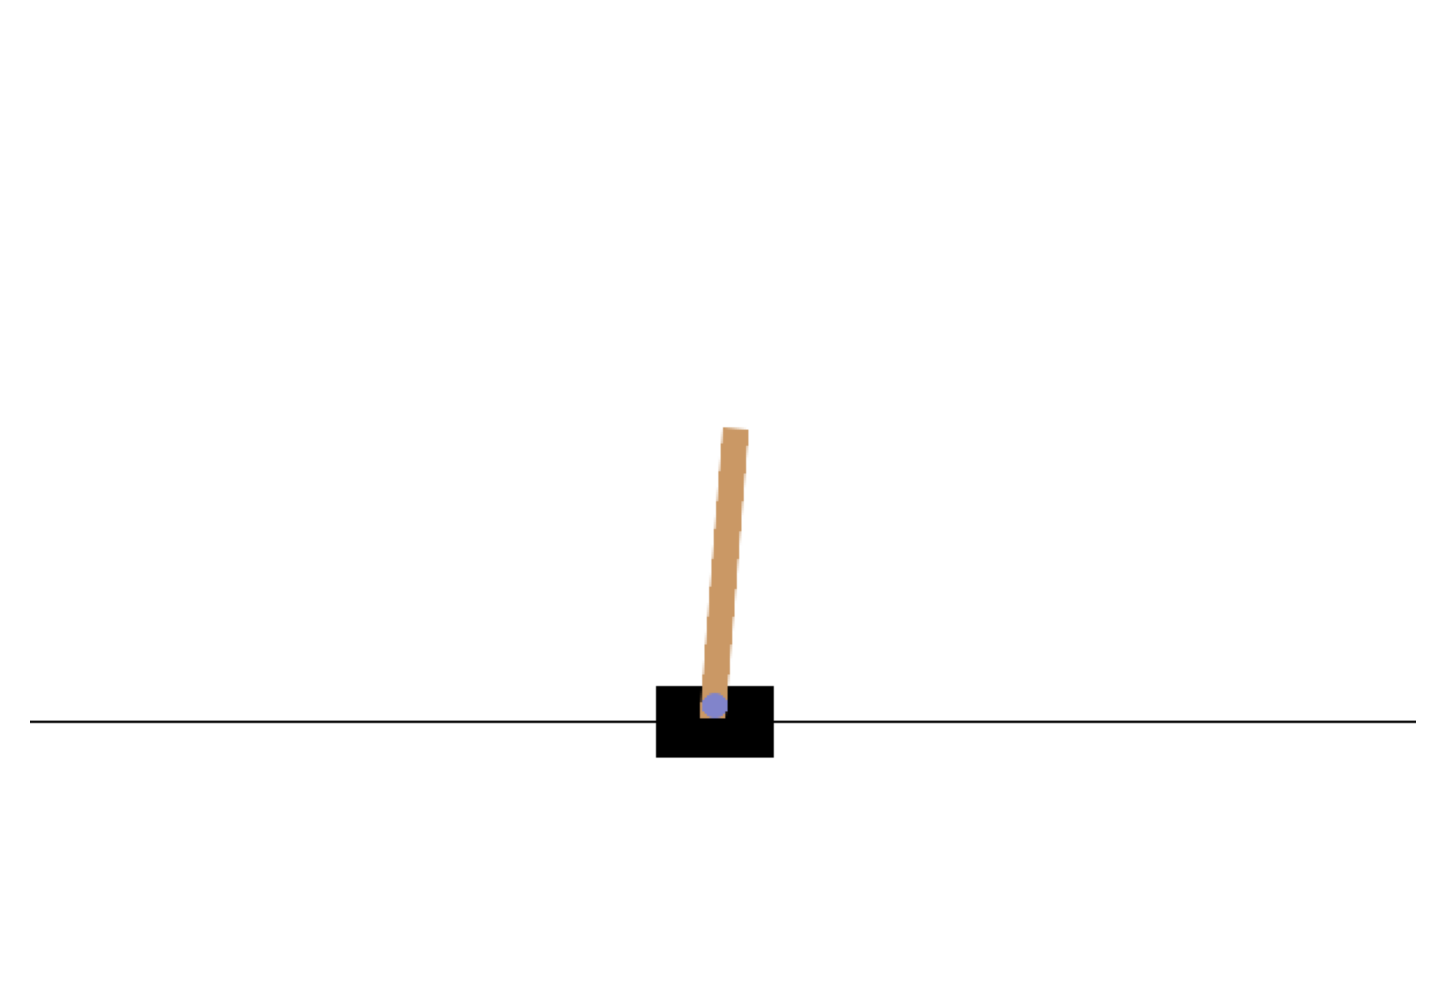

In [35]:
import matplotlib.pyplot as plt
from matplotlib import animation
def save_frames_as_gif(frames, filename):
    
    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1]/100, frames[0].shape[0]/100), dpi=300)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(filename, writer='pillow', fps=60)

actor_pre=ActorSoftmax(4,2)
layer_state_dict = torch.load("models/actor.pt",map_location=torch.device('cpu'))
actor_pre.load_state_dict(layer_state_dict)

env=gym.make('CartPole-v1')

state=env.reset()
frames = []
for i in range(250):
    #print(env.render(mode="rgb_array"))
    frames.append(env.render(mode="rgb_array"))
    state = torch.tensor(state, device="cpu", dtype=torch.float32).unsqueeze(dim=0)
    action =actor_pre(state)
    action=np.argmax(action.detach().numpy()[0])
    next_state,reward,done,_=env.step(action)
    if i%50==0:
        print(i,"   ",reward,done)
    state=next_state

save_frames_as_gif(frames, filename="plots/CartPole.gif")
    
env.close()

## 4. 设置参数

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
class Config:
    def __init__(self) -> None:
        self.env_name = "CartPole-v1" # 环境名字
        self.new_step_api = False # 是否用gym的新api
        self.algo_name = "PPO" # 算法名字
        self.mode = "train" # train or test
        self.seed = 1 # 随机种子
        self.device = "cpu" # device to use
        self.train_eps = 200 # 训练的回合数
        self.test_eps = 20 # 测试的回合数
        self.max_steps = 200 # 每个回合的最大步数
        self.eval_eps = 5 # 评估的回合数
        self.eval_per_episode = 10 # 评估的频率

        self.gamma = 0.99 # 折扣因子
        self.k_epochs = 4 # 更新策略网络的次数
        self.actor_lr = 0.0003 # actor网络的学习率
        self.critic_lr = 0.0003 # critic网络的学习率
        self.eps_clip = 0.2 # epsilon-clip
        self.entropy_coef = 0.01 # entropy的系数
        self.update_freq = 100 # 更新频率
        self.actor_hidden_dim = 256 # actor网络的隐藏层维度
        self.critic_hidden_dim = 256 # critic网络的隐藏层维度

def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,cfg, tag='train'):
    ''' 画图
    '''
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{tag}ing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()

## 5. 开始训练

/home/liuhusheng/anaconda3/envs/rele/lib/python3.9/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/liuhusheng/anaconda3/envs/rele/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/liuhusheng/anaconda3/envs/rele/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


状态空间维度：4，动作空间维度：2
开始训练！
回合：10/200，奖励：18.00，评估奖励：25.40，最佳评估奖励：25.40，更新模型！
回合：20/200，奖励：22.00，评估奖励：30.40，最佳评估奖励：30.40，更新模型！
回合：30/200，奖励：32.00，评估奖励：29.20，最佳评估奖励：30.40
回合：40/200，奖励：32.00，评估奖励：65.60，最佳评估奖励：65.60，更新模型！
回合：50/200，奖励：75.00，评估奖励：35.40，最佳评估奖励：65.60
回合：60/200，奖励：27.00，评估奖励：68.60，最佳评估奖励：68.60，更新模型！
回合：70/200，奖励：185.00，评估奖励：56.80，最佳评估奖励：68.60
回合：80/200，奖励：89.00，评估奖励：86.40，最佳评估奖励：86.40，更新模型！
回合：90/200，奖励：137.00，评估奖励：180.40，最佳评估奖励：180.40，更新模型！
回合：100/200，奖励：117.00，评估奖励：148.20，最佳评估奖励：180.40
回合：110/200，奖励：181.00，评估奖励：167.60，最佳评估奖励：180.40
回合：120/200，奖励：158.00，评估奖励：162.80，最佳评估奖励：180.40
回合：130/200，奖励：200.00，评估奖励：115.40，最佳评估奖励：180.40
回合：140/200，奖励：96.00，评估奖励：75.40，最佳评估奖励：180.40
回合：150/200，奖励：200.00，评估奖励：200.00，最佳评估奖励：200.00，更新模型！
回合：160/200，奖励：121.00，评估奖励：37.00，最佳评估奖励：200.00
回合：170/200，奖励：200.00，评估奖励：200.00，最佳评估奖励：200.00，更新模型！
回合：180/200，奖励：200.00，评估奖励：200.00，最佳评估奖励：200.00，更新模型！
回合：190/200，奖励：200.00，评估奖励：158.00，最佳评估奖励：200.00
回合：200/200，奖励：175.00，评估奖励：131.00，最佳评估奖励：200.00
完成训练！
开始测试！
回合：1/

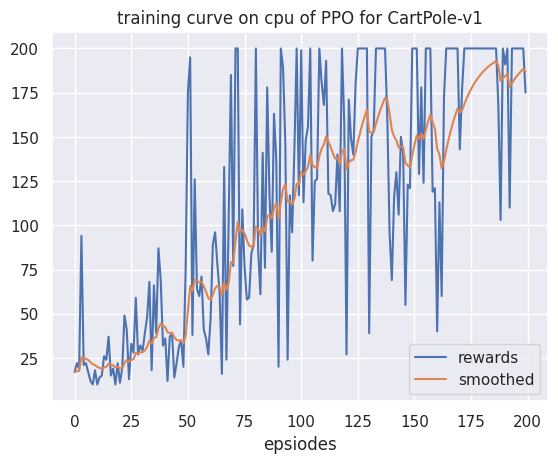

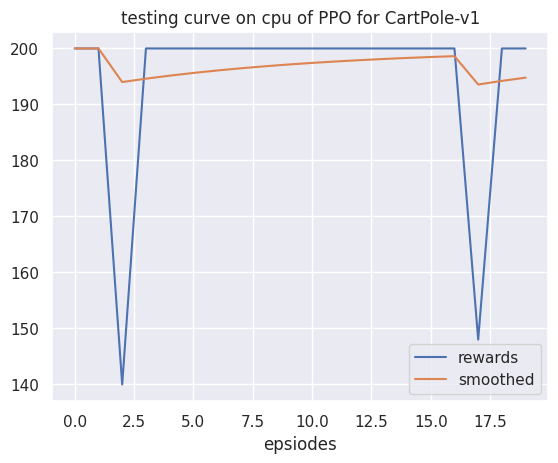

In [8]:
# 获取参数
cfg = Config() 
# 训练
env, agent = env_agent_config(cfg)
best_agent,res_dic = train(cfg, env, agent)
 
plot_rewards(res_dic['rewards'], cfg, tag="train")  
# 测试
res_dic = test(cfg, env, best_agent)
plot_rewards(res_dic['rewards'], cfg, tag="test")  # 画出结果

In [11]:
from torch.distributions import Categorical

In [15]:
probs = torch.Tensor([0.3,0.7])
dist = Categorical(probs)
print(dist)
for i in range(100):
    action = dist.sample()
    print(action)
    log_probs = dist.log_prob(action).detach()
    print(log_probs)

Categorical(probs: torch.Size([2]))
tensor(1)
tensor(-0.3567)
tensor(0)
tensor(-1.2040)
tensor(1)
tensor(-0.3567)
tensor(0)
tensor(-1.2040)
tensor(1)
tensor(-0.3567)
tensor(1)
tensor(-0.3567)
tensor(1)
tensor(-0.3567)
tensor(0)
tensor(-1.2040)
tensor(1)
tensor(-0.3567)
tensor(0)
tensor(-1.2040)
tensor(1)
tensor(-0.3567)
tensor(1)
tensor(-0.3567)
tensor(1)
tensor(-0.3567)
tensor(1)
tensor(-0.3567)
tensor(0)
tensor(-1.2040)
tensor(0)
tensor(-1.2040)
tensor(1)
tensor(-0.3567)
tensor(1)
tensor(-0.3567)
tensor(0)
tensor(-1.2040)
tensor(1)
tensor(-0.3567)
tensor(0)
tensor(-1.2040)
tensor(1)
tensor(-0.3567)
tensor(1)
tensor(-0.3567)
tensor(0)
tensor(-1.2040)
tensor(1)
tensor(-0.3567)
tensor(1)
tensor(-0.3567)
tensor(0)
tensor(-1.2040)
tensor(1)
tensor(-0.3567)
tensor(1)
tensor(-0.3567)
tensor(1)
tensor(-0.3567)
tensor(0)
tensor(-1.2040)
tensor(1)
tensor(-0.3567)
tensor(1)
tensor(-0.3567)
tensor(1)
tensor(-0.3567)
tensor(1)
tensor(-0.3567)
tensor(1)
tensor(-0.3567)
tensor(1)
tensor(-0.3567)
te